In [2]:
import os 
os.chdir('../')

In [1]:
%reload_ext autoreload
%autoreload 2

In [107]:
import torch

from models import build_model
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from main import get_datasets

from visualize import visualize_prediction_results, plot_results

from analysis.image import show_image

[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/home/nazir/anaconda3/envs/detr_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nazir/anaconda3/envs/detr_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/nazir/anaconda3/envs/detr_env/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/nazir/anaconda3/envs/detr_env/lib/python3.8/site-packages/numpy/matrixlib/__init__.py", line 6, in <module>
    __all__ = defmatrix.__all__
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.lib failed: Traceback (mos

# Load the Model

In [4]:
default_settings = {
    'deformable_detr': {
        'lr': 2e-4,
        'lr_backbone': 2e-5,
        'epochs': 50,
        'lr_drop': 40,
        'dim_feedforward': 1024,
        'num_queries': 300,
        'set_cost_class': 2,
        'cls_loss_coef': 2
    },
    'detr': {
        'lr': 1e-4,
        'lr_backbone': 1e-5,
        'epochs': 300,
        'lr_drop': 200,
        'dim_feedforward': 2048,
        'num_queries': 100,
        'set_cost_class': 1,
        'cls_loss_coef': 1
    }
}


def set_model_defaults(args):
    defaults = default_settings[args.model]
    runtime_args = vars(args)
    for k, v in runtime_args.items():
        if v is None and k in defaults:
            setattr(args, k, defaults[k])
    return args

In [56]:
data_root = '/home/nazir/datasets/'
args = edict(
    maha_train=False,
    dataset='bdd',
    dataset_file="bdd",
    data_root=data_root,
    bdd_root='/home/nazir/datasets/bdd100k/det/bdd100k_images_100k/bdd100k/images/100k/',
    bdd_ann_root_train = '/home/nazir/datasets/bdd100k/det/train_bdd_converted.json',
    bdd_ann_root_test = '/home/nazir/datasets/bdd100k/det/val_bdd_converted.json',
    open_root = '/home/nazir/datasets/OpenImages/ood_classes_rm_overlap/images',
    open_ann_root = '/home/nazir/datasets/OpenImages/ood_classes_rm_overlap/COCO-Format/val_coco_format.json',
    coco_path = os.path.join(data_root, 'COCO'),
    voc_path = os.path.join(data_root, 'PascalVOC'),
    model='deformable_detr',
    lr_drop=24,
    load_backbone='dino',
    project_dim=64,
    vmf_weight=1.5,
    siren=True,
    resume='ckpts/checkpoint_bdd_siren.pth',
    device='cuda',
    dim_feedforward= 1024,
    num_queries= 300,
    set_cost_class= 2,
    cls_loss_coef= 2,
    bbox_loss_coef=5,
    giou_loss_coef=2,
    masks=False,
    aux_loss=False,
    object_embedding_loss=False,
    hidden_dim=256,
    position_embedding='sine',
    lr_backbone=2e-5,
    num_feature_levels=4,
    backbone='resnet50',
    dilation=False,
    nheads=8,
    enc_layers=6,
    dec_layers=6,
    dropout=0.1,
    dec_n_points=4,
    enc_n_points=4,
    two_stage=False,
    with_box_refine=False,
    obj_embedding_head='intermediate',
    learnable_kappa_init=10,
    siren_on_the_logits=False,
    set_cost_bbox=5,
    set_cost_giou=2,
    focal_alpha=0.25,
    filter_pct=-1,
    cache_mode=False
)


args = set_model_defaults(args)

In [15]:
model, criterion, postprocessors = build_model(args)

In [20]:
_ = model.eval()
_ = model.cuda()

In [23]:
ckpt = torch.load(args.resume, map_location='cpu')

In [27]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'lr_scheduler', 'epoch', 'args'])

In [100]:
ckpt.keys()

dict_keys(['model', 'optimizer', 'lr_scheduler', 'epoch', 'args'])

In [106]:
ckpt['model'].keys()

odict_keys(['transformer.level_embed', 'transformer.encoder.layers.0.self_attn.sampling_offsets.weight', 'transformer.encoder.layers.0.self_attn.sampling_offsets.bias', 'transformer.encoder.layers.0.self_attn.attention_weights.weight', 'transformer.encoder.layers.0.self_attn.attention_weights.bias', 'transformer.encoder.layers.0.self_attn.value_proj.weight', 'transformer.encoder.layers.0.self_attn.value_proj.bias', 'transformer.encoder.layers.0.self_attn.output_proj.weight', 'transformer.encoder.layers.0.self_attn.output_proj.bias', 'transformer.encoder.layers.0.norm1.weight', 'transformer.encoder.layers.0.norm1.bias', 'transformer.encoder.layers.0.linear1.weight', 'transformer.encoder.layers.0.linear1.bias', 'transformer.encoder.layers.0.linear2.weight', 'transformer.encoder.layers.0.linear2.bias', 'transformer.encoder.layers.0.norm2.weight', 'transformer.encoder.layers.0.norm2.bias', 'transformer.encoder.layers.1.self_attn.sampling_offsets.weight', 'transformer.encoder.layers.1.self_

In [30]:
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

# DataLoader

In [57]:
dataset_train, dataset_val = get_datasets(args)

loading annotations into memory...
Done (t=6.94s)
creating index...
index created!
loading annotations into memory...
Done (t=1.39s)
creating index...
index created!


In [81]:
img, lbl = dataset_val[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


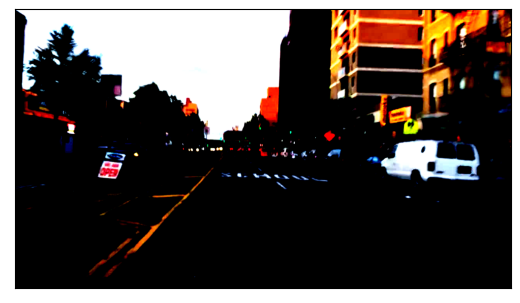

In [82]:
show_image(img)

In [108]:
with torch.no_grad():
    out = model(img.unsqueeze(0).cuda())

In [109]:
out.keys()

dict_keys(['pred_logits', 'pred_boxes', 'pen_features', 'epoch', 'cls_head', 'project_features', 'project_head', 'learnable_kappa'])

In [ ]:
orig_target_sizes = torch.stack([t["orig_size"] for t in lbl], dim=0)

In [114]:
lbl.keys()

dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'orig_size', 'size'])

In [121]:
results = postprocessors['bbox'](out, lbl['orig_size'].unsqueeze(0).cuda())

In [139]:
results[0].keys()

visualize_prediction_results(edict(tensors=[img]), results, 'output', lbl, ood=False)

TypeError: float() argument must be a string or a number, not '_NoValueType'

<Figure size 1600x1000 with 0 Axes>

In [135]:
img.tensors

AttributeError: 'Tensor' object has no attribute 'tensors'

In [119]:
lbl['orig_size'].shape

torch.Size([2])

In [99]:
out['learnable_kappa']

Linear(in_features=10, out_features=1, bias=False)

In [ ]:
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                 pin_memory=True)

In [143]:
out.keys()

dict_keys(['pred_logits', 'pred_boxes', 'pen_features', 'epoch', 'cls_head', 'project_features', 'project_head', 'learnable_kappa'])

In [144]:
print(out['epoch'])

None


In [145]:
ckpt['args']

Namespace(airbus_path='/nobackup/dataset/my_xfdu/airbus-ship-detection', aux_loss=True, backbone='resnet50', batch_size=1, bbox_loss_coef=5, bdd_ann_root_test='/nobackup/dataset/my_xfdu/bdd-100k/bdd100k/val_bdd_converted.json', bdd_ann_root_train='/nobackup/dataset/my_xfdu/bdd-100k/bdd100k/train_bdd_converted.json', bdd_root='/nobackup/dataset/my_xfdu/bdd-100k/bdd100k/images/100k/', cache_mode=False, cache_path=None, center_adaptive=False, center_loss=True, center_loss_scheme_project=1, center_loss_scheme_v1=0, center_revise=True, center_temp=0.1, center_vmf_estimate_kappa=False, center_vmf_fix_kappa=False, center_vmf_learnable_kappa=True, center_vmf_no_kappa=False, center_vmf_no_zp=False, center_weight=1.5, clip_max_norm=0.1, cls_loss_coef=2, coco_panoptic_path=None, coco_path='/nobackup/dataset/my_xfdu/coco2017', csi=False, data_root='/nobackup/dataset/my_xfdu/', dataset='bdd', dataset_file='bdd', dec_layers=6, dec_n_points=4, device='cuda', dice_loss_coef=1, dilation=False, dim_feed